In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!gdown --id 1L843daxmFSZD_hyz_AMIQ6-dzTPDaoGJ

Downloading...
From: https://drive.google.com/uc?id=1L843daxmFSZD_hyz_AMIQ6-dzTPDaoGJ
To: /content/font_fam-20220209T082332Z-001.zip
100% 86.7M/86.7M [00:00<00:00, 207MB/s]


In [ ]:
!unzip --qq "/content/font_fam-20220209T082332Z-001.zip" -d"/content/data/"

In [ ]:
#path_data = "/content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/font_recognition/train/font_fam/"
path_data = "/content/data/font_fam/"

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

from tqdm import tqdm

import cv2

%matplotlib inline

In [ ]:
import cv2
def pil_image(img_path):
    #pil_im =PIL.Image.open(img_path).convert('L')
    #pil_im =PIL.Image.open(img_path)
    
    pil_im = cv2.imread(img_path)
    pil_im=cv2.resize(img, (224, 224))
    #imshow(np.asarray(pil_im))
    return pil_im

# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [ ]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [ ]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [ ]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [ ]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (224, 224))
    return laplacian

## Preparing Dataset

In [ ]:
data_path = "/content/data/font_fam/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
def conv_label(label):
    if label == 'TH_Charm_of_AU':
        return 0
    elif label == 'TH_Mali_Grade6':
        return 1
    elif label == 'THSarabun':
        return 2
    elif label == 'Kunlasatri':
        return 3
    elif label == 'CORDIA':
        return 4
    elif label == 'Angsana_New':
        return 5
    elif label == 'DM_Shining Star_Regular':
        return 6
    elif label == 'TH_Chakra_Petch':
        return 7
    elif label == 'FC_Knomphing_Regular':
        return 8
    elif label == 'fonttintin':
        return 9

In [ ]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a): 
    print(list(i))

['blur', 'noise', 'affine', 'gradient']


In [ ]:
imagePaths[0]

'/content/data/font_fam/Kunlasatri/1ad5b723_Kunlasatri_16px_italic_bold.png'

In [3]:
counter=0
for imagePath in imagePaths[:5000]:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    # augument=["noise","blur","affine","gradient"]
    # for l in range(0,len(augument)):
    
    #     a=itertools.combinations(augument, l+1)

    #     for i in list(a): 
    #         combinations=list(i)
    #         print(len(combinations))
    #         temp_img = pil_img
    #         for j in combinations:
            
    #             if j == 'noise':
    #                 # Adding Noise image
    #                 temp_img = noise_image(temp_img)
                    
    #             elif j == 'blur':
    #                 # Adding Blur image
    #                 temp_img = blur_image(temp_img)
    #                 #imshow(blur_img)
                    
    
    #             elif j == 'affine':
    #                 open_cv_affine = np.array(pil_img)
    #                 # Adding affine rotation image
    #                 temp_img = affine_rotation(open_cv_affine)

    #             elif j == 'gradient':
    #                 open_cv_gradient = np.array(pil_img)
    #                 # Adding gradient image
    #                 temp_img = gradient_fill(open_cv_gradient)
  
    #         temp_img = img_to_array(temp_img)
    #         data.append(temp_img)
    #         labels.append(label)

In [ ]:
mylist = list(dict.fromkeys(labels))
#len(mylist)
mylist

[]

In [2]:
# data[0].shape

In [ ]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [ ]:

mylist = list(dict.fromkeys(trainY))
#len(mylist)
mylist

[8, 9, 4, 2, 7, 5, 6, 0, 1, 3]

In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=10)
testY = to_categorical(testY, num_classes=10)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [ ]:
#K.set_image_dim_ordering('tf')

K.set_image_data_format('channels_last')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [ ]:
 def create_model():
  new_input = tf.keras.layers.Input(shape=(224, 224, 3))
  base_model = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=new_input, weights="imagenet", pooling='avg')

  for layer in base_model.layers:
	    layer.trainable = True  
  #model = base_model.output
  outputs = tf.keras.layers.Dense(10, activation='softmax')(base_model.output)
  model = tf.keras.Model(new_input, outputs)

  #model.summary()
  return model

In [ ]:
import tensorflow as tf

batch_size = 128
epochs = 50
model= create_model()
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

path_s = "/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/"
filepath= path_s + "top_model_mobile.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [ ]:
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.3719 - accuracy: 0.0907
Epoch 00001: val_loss improved from inf to 2.82269, saving model to /content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/top_model_mobile.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


12/12 [==============================] - 26s 1s/step - loss: 2.3719 - accuracy: 0.0907 - val_loss: 2.8227 - val_accuracy: 0.1020
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.2968 - accuracy: 0.1160
Epoch 00002: val_loss did not improve from 2.82269
12/12 [==============================] - 8s 640ms/step - loss: 2.2968 - accuracy: 0.1160 - val_loss: 3.0077 - val_accuracy: 0.1160
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 2.2939 - accuracy: 0.1127
Epoch 00003: val_loss did not improve from 2.82269
12/12 [==============================] - 8s 634ms/step - loss: 2.2939 - accuracy: 0.1127 - val_loss: 2.9958 - val_accuracy: 0.1160
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 2.2928 - accuracy: 0.1133
Epoch 00004: val_loss did not improve from 2.82269
12/12 [==============================] - 8s 651ms/step - loss: 2.2928 - accuracy: 0.1133 - val_loss: 2.9891 - val_accuracy: 0.1160
Epoch 5/50
12/12 [=========================

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [1]:
# from keras.models import load_model
# model = load_model(path_s + "top_model.h5")

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14993298053741455
Test accuracy: 0.6474359035491943


In [ ]:
!pwd

/content


In [ ]:
img_path="/content/drive/MyDrive/adobe/sample/sample.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [ ]:
def rev_conv_label(label):
    if label == 0 :
        return 'Lato'
    elif label == 1:
        return 'Raleway'
    elif label == 2 :
        return 'Roboto'
    elif label == 3 :
        return 'Sansation'
    elif label == 4:
        return 'Walkway'

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
# y = model.predict_classes(data)

y = model.predict(data)
y = np.round(y).astype(int)

In [ ]:
y[0]

array([0, 0, 0, 0, 0])

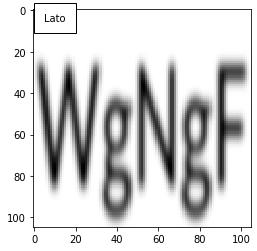

In [ ]:
label = rev_conv_label(y[0,0])
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()